In [7]:
from __future__ import print_function, division

import time
import os
import copy
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
from skimage import io, transform

import torch
print(torch.__version__)
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision.utils as utils
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torchvision import datasets, models, transforms
import torchvision

from utils import *
from stanford40_dataset import Stanford40Dataset
from model.reflectnet import ReflectNet
from model.multiprongnet import MultiProngNet

USE_GPU = True
dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')
    
print('using device:', device)

%load_ext autoreload
%autoreload 2

1.5.0
using device: cuda:0
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

train = Stanford40Dataset("../data/Stanford40", "train", transform=data_transforms['train'])
train_loader = DataLoader(train, batch_size=4, num_workers=4, shuffle=True)

test = Stanford40Dataset("../data/Stanford40", "test", transform=data_transforms['test'])
val_set, test_set = torch.utils.data.random_split(test, [2766, 2766])
val_loader = DataLoader(val_set, batch_size=4, num_workers=4)
test_loader = DataLoader(test_set, batch_size=4, num_workers=4)

dataloaders = {"train": train_loader, "val": val_loader, "test": test_loader}
dataset_sizes = {"train": len(train), "val": len(val_set), "test": len(test_set)}

print(dataset_sizes)

{'train': 4000, 'val': 2766, 'test': 2766}


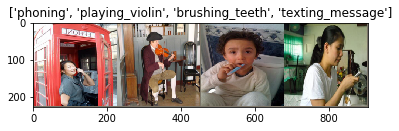

In [9]:
inputs, classes = next(iter(train_loader))
indices = classes.argmax(dim=1)
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in indices])

In [10]:
my_model = MultiProngNet()
my_model = my_model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(my_model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-5)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)

In [11]:
my_model, train_loss_hist, val_loss_hist = train_model(my_model, 
                                                       criterion, 
                                                       optimizer_ft, 
                                                       exp_lr_scheduler, 
                                                       dataloaders, 
                                                       dataset_sizes,
                                                       device,
                                                       num_epochs=50)

Epoch 0/49
----------


KeyboardInterrupt: 

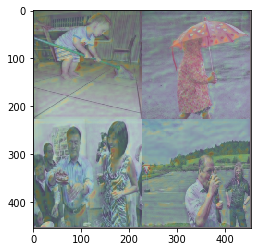

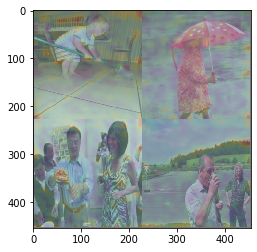

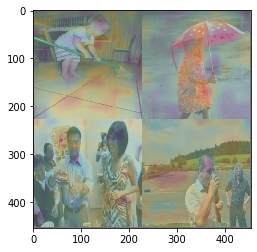

predicted: jumping, actual: cleaning_the_floor


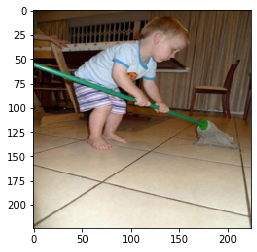

predicted: rowing_a_boat, actual: holding_an_umbrella


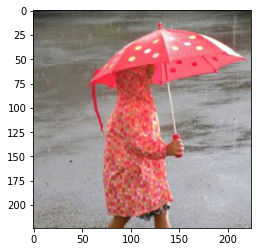

predicted: fixing_a_bike, actual: pouring_liquid


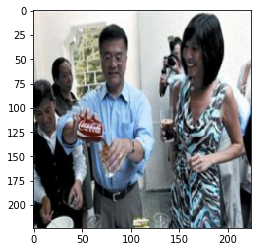

predicted: jumping, actual: drinking


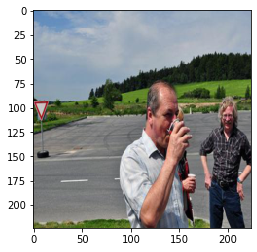

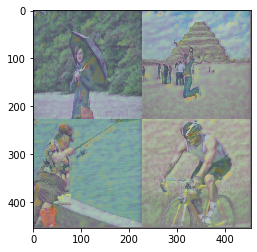

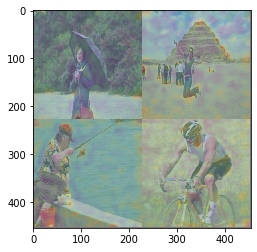

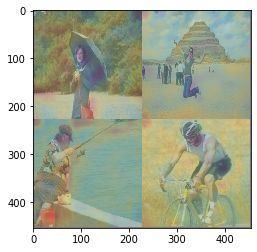

predicted: jumping, actual: holding_an_umbrella


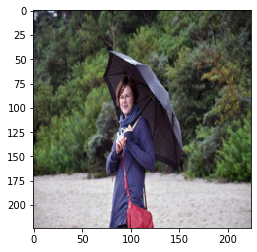

predicted: jumping, actual: jumping


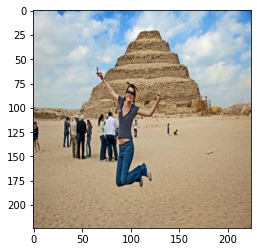

predicted: rowing_a_boat, actual: fishing


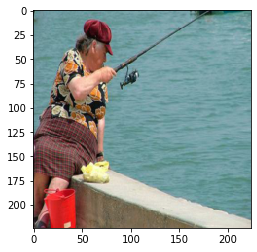

predicted: jumping, actual: riding_a_bike


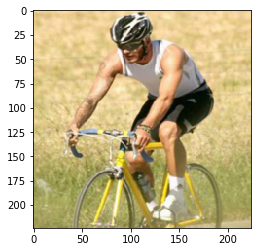

In [12]:
visualize_model(my_model, dataloaders, dataset_sizes, device)

In [ ]:
torch.save(my_model.state_dict(), "multiprongnet.tar")

In [13]:
my_model = MultiProngNet()
my_model.load_state_dict(torch.load("multiprongnet.tar"))

<All keys matched successfully>

In [21]:
from utils import evaluate
my_model = my_model.to(device)
criterion = nn.CrossEntropyLoss()
evaluate(my_model,dataloaders,dataset_sizes,device, criterion)

Test set loss: 1.3728 Acc: 0.6667
